In [9]:
%matplotlib inline
import time
import pickle
import numpy as np
from qiskit import *
from qiskit import IBMQ
import matplotlib.pyplot as plt
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

date = '04-23-2020-1800'
multiplier = 16
machine = 'ibmq_london'

In [10]:
#Get provider
IBMQ.save_account('f2fcc2d8cff908878030fcb87e40c02f6dfe5cf467c5b948c1ae0b091b0f66b20bb4fc7078fedf45ed6379e336baea7572bee513469a4d4abbfc649ec82f1c16')
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend(machine)

configrc.store_credentials:WARNING:2020-07-17 14:20:39,303: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2020-07-17 14:20:41,878: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
#Get identity gate time
backend_properties = backend.properties()
dt = backend_properties._gates['id'][0,]['gate_length'][0] * 1e6

In [12]:
def flip(wait1, wait2, gate):
    
# initialize quantum circuit
    circuit = QuantumCircuit(1,1)
    
# define wait gates
    w_circuit = QuantumCircuit(1, name='Wait Gate: ' + str(round(wait1 * dt, 3)) + 'μs')

    for t in range(wait1):
        w_circuit.i(0)

    w = w_circuit.to_instruction()

# wait
    circuit.append(w, [0])
    
# qubit 1 rotation of pi along x
    if (gate == True):
        circuit.h(0)
    
# define wait gates
    w_circuit = QuantumCircuit(1, name='Wait Gate: ' + str(round(wait2 * dt, 3)) + 'μs')

    for t in range(wait2):
        w_circuit.i(0)

    w = w_circuit.to_instruction()

# wait
    circuit.append(w, [0])
    
# measure circuit
    circuit.measure(0, 0)
    
    return circuit

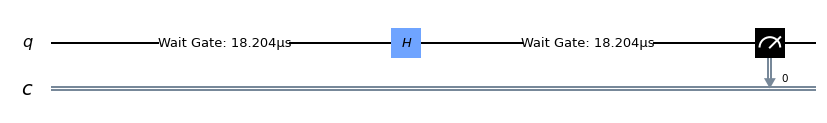

In [13]:
circuits = []
for c in range(64):
    if (c <= 31):
        circuits.append(flip(c*multiplier, 0, False))
    else:
        circuits.append(flip(32*multiplier, (c-31)*multiplier, True))

# print circuit
circuits[63].draw(output='mpl')

In [14]:
start_timer = time.time()
results = []
job = execute(circuits, backend, shots=8192, optimization_level=0)

# monitor job
job_monitor(job)
    
# get results
result = job.result()

print(str((time.time()-start_timer)/60.) + 'min')

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
counts = []
wait_time = []
for count in range(len(circuits)):
    counts.append(result.get_counts(circuits[count])['1'] / 8192)
    wait_time.append(dt*count*multiplier)
    
plt.plot(wait_time, counts)
plt.ylim(-0.05,1.05)
plt.xlabel('Wait Time [μs]')
plt.ylabel('Count [%]')
plt.legend(['Experimental'])
plt.savefig('Experimental_LMEZ_XGate_XAXIS.pdf')
plt.show()